In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from shapely import Polygon
import geopandas as gpd

In [2]:
geom = Polygon([
    (-91.3011932, 33.852768),
    (-90.9098053, 33.8413567),
    (-90.9194183, 33.5069017),
    (-91.2957001, 33.509193),
    (-91.3005066, 33.8579026)
])

gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326")
gdf = gdf.to_crs(32615)  # UTM 15N
selected_geom = gdf.geometry.union_all().envelope

In [3]:
items_gdf = pc_query(
    collections="landsat-c2-l2",
    geometry=selected_geom,
    datetime="1984/2024",
    crs=gdf.crs,
    query={"eo:cloud_cover": {"lt": 50}} # return scenes with less than 50% cloud cover 
)
print(f"Found {len(items_gdf)} items")

Found 3218 items


In [ ]:
client = Client(n_workers=os.cpu_count() // 2, memory_limit="2GB")
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41135,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37537,Total threads: 1
Dashboard: http://127.0.0.1:33121/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:33567,


: 

In [ ]:
da = prepare_timeseries(
    items_gdf,
    geometry=selected_geom,
    crs=gdf.crs,
    bands=["green", "nir08", "qa_pixel"],
    chunks={"time": 1, "x": 512, "y": 512},
    masked=True,
    max_workers=4,
)

Processing items:  68%|██████▊   | 1250/1840 [1:20:25<32:01,  3.26s/timestep]  

In [ ]:
qa = da.sel(band="qa_pixel").astype("uint32")

mask = (
    ((qa & (1 << 3)) == 0) &  # cloud
    ((qa & (1 << 4)) == 0) &  # cloud shadow
    ((qa & (1 << 5)) == 0) &  # snow
    ((qa & (1 << 7)) == 0)    # water
)

da = da.where(~mask)

In [ ]:
def dn2sr(da):
    """
    Convert Digital Number (DN) to Surface Reflectance (SR) for Landsat Collection 2 Level 2 data.
    See https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
    """
    return (da * 0.0000275) - 0.2

def calculate_ndwi(da):
    """Calculate NDWI from green and nir bands."""
    green = dn2sr(da.sel(band="green"))
    nir = dn2sr(da.sel(band="nir"))
    
    ndwi = (green - nir) / (green + nir)
    ndwi = ndwi.clip(-1, 1)  # Clip values to [-1, 1]
    return ndwi

ndwi = calculate_ndwi(da)
yearly_ndwi = ndwi.resample(time="1Y").mean().compute()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

2025-06-29 16:17:09,049 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/utils_comm.py", lin

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
2025-06-29 16:17:11,032 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/home/dh2306/miniforge3/envs/py312/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dh2306/miniforge3/envs/py312/lib/python3.12/asyncio/base_events.py", line 664, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/home/dh2306/miniforge3/envs/py312/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above exception, another excep

Error in callback <function _draw_all_if_interactive at 0x72d775989b20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

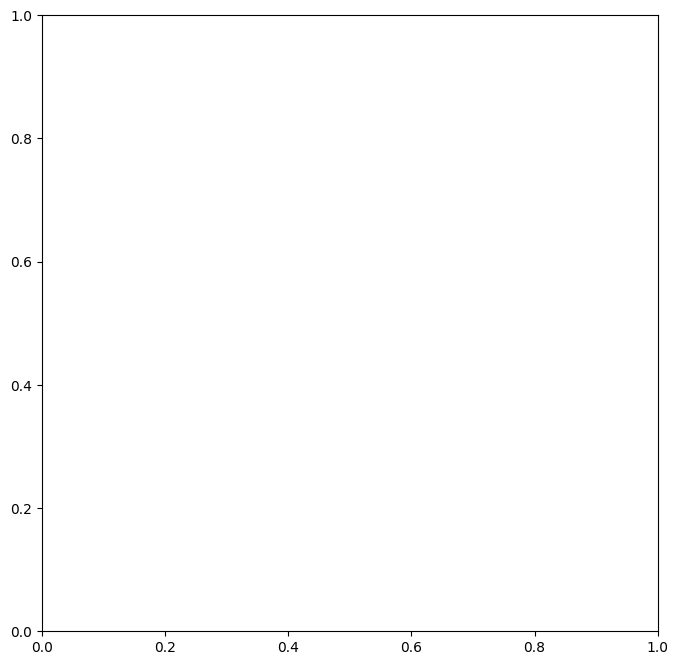

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    yearly_ndwi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='GnBu', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    
    fig.suptitle(f"Mississippi River Landsat Yearly Mean NDWI\n" + \
                    f"{yearly_ndwi['time'][frame].dt.strftime('%Y').values}")
    
init_plot = yearly_ndwi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'NDWI'}, cmap='GnBu', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(yearly_ndwi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once'))

In [ ]:
items_gdf['properties.datetime']

0      2024-12-31 16:37:36.266
1      2024-12-07 16:37:10.143
2      2024-12-06 16:43:48.984
3      2024-12-06 16:43:25.093
4      2024-11-29 16:37:45.106
                 ...          
2280   1984-06-23 16:12:05.118
2281   1984-06-23 16:11:41.287
2282   1984-06-07 16:11:50.139
2283   1984-05-06 16:10:59.176
2284   1984-04-29 16:04:36.633
Name: properties.datetime, Length: 2285, dtype: datetime64[ms]